In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [3]:
####################################
def TFRcurve(x, slope, zp, A, band, C_zp):

#         logW0 = 2.0+0.4*(1+np.tanh(logW0))

    if band in ['w1', 'w2']:
        logW0=2.4 # 2.375
    elif band in ['i', 'z']:
        logW0=2.5
    else:
        logW0=2.5

    logW = x

    X0 = logW0 - 2.5
    X = logW-2.5

    B = -2.*A*X0

    M = slope*X+(zp+C_zp)

    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))


    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

def rrmmss(logWimx, mag, logWimx_e, slope, zp, A, band, C_zp):
    
    mag_fit = TFRcurve(logWimx, slope, zp, A, band, C_zp)
    delta = mag-mag_fit
    
    Y_fit2 = delta
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N))
    
    return rms

def rmsMaker(logWimx, mag, logWimx_e, slope, zp, A, band, C_zp):
    

    rms_all = rrmmss(logWimx, mag, logWimx_e, slope, zp, A, band, C_zp)
    
    indx, = np.where((mag<=-17) & (mag>-19))
    rms_17_19 = rrmmss(logWimx[indx], mag[indx], logWimx_e[indx], slope, zp, A, band, C_zp)
    indx, = np.where((mag<=-18) & (mag>-20))
    rms_18_20 = rrmmss(logWimx[indx], mag[indx], logWimx_e[indx], slope, zp, A, band, C_zp)     
    indx, = np.where((mag<=-19) & (mag>-21))
    rms_19_21 = rrmmss(logWimx[indx], mag[indx], logWimx_e[indx], slope, zp, A, band, C_zp)  
    indx, = np.where((mag<=-21))
    rms_21___ = rrmmss(logWimx[indx], mag[indx], logWimx_e[indx], slope, zp, A, band, C_zp)
    

    rms = [rms_all, rms_17_19, rms_18_20, rms_19_21, rms_21___]
    
    return rms

In [4]:
# def CurveFUN(x, a, b, c):
#     return a*x**2+b*x+c
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def makeTFandPLOT(ax, band = 'i', xLim = (1.2,3.1), yLim = (18.75,7.25)):

    table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                            filling_values=-1, names=True, dtype=None, encoding=None)

    addSouth=False
    if band in ['w1', 'w2']:
        addSouth=True
    
    Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False, 
                                                addSouth=addSouth, pgcFaint=I_maglim)

    zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim)
    slope = zp_calibs['slope']
    zp    = zp_calibs['zp']
    zp_e = zp_calibs['zp_e']
    
    C_zp = 0
    e_czp = 0
    if band == 'u':
        C_zp = -0.08
        e_czp = 0.30
    if band == 'g':
        C_zp = -0.11  
        e_czp = 0.18
    if band == 'r':
        C_zp = -0.08
        e_czp = 0.13
    if band == 'i':
        C_zp = -0.04
        e_czp = 0.10
    if band == 'z':
        C_zp = -0.08 
        e_czp = 0.11
        

    ####################################
    def CurveFUN(x, A):
        
#         logW0 = 2.0+0.4*(1+np.tanh(logW0))
        
        if band in ['w1', 'w2']:
            logW0=2.4 # 2.375
        elif band in ['i', 'z']:
            logW0=2.5
        else:
            logW0=2.5

        logW = x

        X0 = logW0 - 2.5
        X = logW-2.5
        
        B = -2.*A*X0
#         B = -1.5*A*X0
#         B = -0.5*A/np.sqrt(X0)

        M = slope*X+(zp+C_zp)
        
        delta = ((A*X**2+B*X) - (A*X0**2+B*X0))
#         delta = ((A*X**3+B*X**2) - (A*X0**3+B*X0**2))
#         delta = ((A*np.sqrt(X)+B*X) - (A*np.sqrt(X0)+B*X0))
        

        try:
            delta[np.where(logW<logW0)] = 0
        except:
            if logW<logW0:
                delta = 0

        return M+delta
    ####################################
        
        

#     Clusters = allCluster(table, band=band, slope=slope, pgcFaint=I_maglim)

    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    


    N_cluster = 0

    boolean = True
    for i, key in enumerate(Clusters):
            myCluster = Clusters[key]
            zp_ = myCluster['zp']
            I_mag = myCluster['mag']-zp_+(zp+C_zp)
            logWimx = myCluster['logWimx']
            pgc =  myCluster['pgc']
            I_mag_w = myCluster['mag_w']-zp_+(zp+C_zp)
            logWimx_w = myCluster['logWimx_w']    
            

            indx = []
            indx_ = []    
            for i, id in enumerate(pgc):
                if not id in I_maglim:
                    indx.append(i)
                else:
                    indx_.append(i)             

            if boolean:
                logWimx_=logWimx[indx]
                mag_=I_mag[indx]
                logWimx_e_=myCluster['logWimx_e'][indx]
                boolean = False
            else:                    
                logWimx_=np.concatenate((logWimx_, logWimx[indx]))
                mag_=np.concatenate((mag_, I_mag[indx]))
                logWimx_e_=np.concatenate((logWimx_e_, myCluster['logWimx_e'][indx]))               
                    
            alpha = 0.4
            if addSouth:
                alpha = 0.3
            
            ax.plot(logWimx[indx], I_mag[indx], '.', color=dye[band], alpha=alpha, 
                    ms=7, mec=dye[band])
            N_cluster += len(logWimx[indx])
            ax.plot(logWimx[indx_], I_mag[indx_], 'ko', alpha=0.3, markersize=5, markeredgecolor='none')        

            ax.plot(logWimx_w, I_mag_w, 'ko', alpha=0.3, 
                    ms=5, markeredgecolor='none')
            
            
   
    #################
    iindx, = np.where(logWimx_<2.8)
    fit, cov = curve_fit(CurveFUN, logWimx_[iindx], mag_[iindx], sigma=np.abs(logWimx_e_[iindx]*slope))
    A = fit[0]
#     logW0 = fit[1]

    print A#, 2.0+0.4*(1+np.tanh(logW0))

    print '%.2f'%A+'$\pm$'+'%.2f'%np.sqrt(cov[0])
    #################
    
    rms = rmsMaker(logWimx_, mag_, logWimx_e_, slope, zp, A, band, C_zp)
    print band, len(logWimx_), N_cluster, '%.2f'%slope0, '%.2f'%slope_e0, rms
    
    m0 = zp_calibs['slope']
    b0 = zp_calibs['zp']
    dm0 = zp_calibs['slope_e']
    db0 = zp_calibs['zp_e']
    mag_ = zp_calibs['MAG']
    logWimx_ = zp_calibs['logWimx']
    mag_e = zp_calibs['mag_e']
    logWimx_e = zp_calibs['logWimx_e']
    pgc = zp_calibs['pgc']



    indx = []
    indx_ = []    
    for i, id in enumerate(pgc):
        if not id in calib_maglim:
            indx.append(i)
        else:
            indx_.append(i)  




    ax.plot(logWimx_[indx], mag_[indx], 'o',  
                            markersize=5, color = 'k', mew=0.7)
    N_calib = len(logWimx_[indx])

    if len(indx_)>0:
                ax.plot(logWimx_[indx_], mag_[indx_], 'o',  
                        color='k', markersize=5, alpha=1., markerfacecolor='white')


    x = np.linspace(1.7,2.9,100)
    y = slope*(x-2.5)+(zp+C_zp)
    ax.plot(x,y, 'r--')  
    
    y = CurveFUN(x, A)
    ax.plot(x,y, 'k-') 

    if band=='i':
        x = np.linspace(1.6,2.4,20)
        ax.plot(x,-17*x/x,'--', lw=1, color='navy')
        ax.text(2.45,-16.8, r'$M_{i^*}=-17$'+' mag', fontsize=11, color='navy')
    
#     if band=='u':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17+(2.68*(x-2.5)+1.58),'--', lw=1, color='navy')  
#     if band=='g':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17+(0.84*(x-2.5)+0.64),'--', lw=1, color='navy')  
#     if band=='r':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17+(0.27*(x-2.5)+0.23),'--', lw=1, color='navy')  
#     if band=='z':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17-(0.25*(x-2.5)+0.12),'--', lw=1, color='navy')          
    if band=='w1':
        x = np.linspace(1.6,2.4,20)
        ax.plot(x,-16.1*x/x,'--', lw=1, color='navy')
        ax.text(2.38,-16.3, r'$M_{W1^*}=-16.1$'+' mag', fontsize=11, color='navy')
#     if band=='w2':
#         x = np.linspace(1.6,2.4,20)
#         ax.plot(x,-17-(1.32*(x-2.5)-1.04),'--', lw=1, color='navy')        
    
        

    ax.text(2.15,-14, "%d" % N_cluster+' Cluster Galaxies', fontsize=12, color='k')
    ax.text(2.15,-13, "%d" % N_calib+' Zeropoint Galaxies', fontsize=12, color='k')
    
    yLim = (-12.03,-24.97)
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_xticks(np.arange(1.50, 3.5, step=0.5))
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
        x_ax.set_xticks(np.arange(1.5, 3.5, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14)     

            
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.95*Xlm[0]+0.05*Xlm[1]
#     y0 = 0.2*Ylm[0]+0.80*Ylm[1]
#     ax.text(x0,y0, "A = "+"%.2f" % A+'$\pm$'+"%.2f" % Ae, fontsize=12, color='k')
#     y0 = 0.3*Ylm[0]+0.70*Ylm[1]
#     ax.text(x0,y0, "B = "+"%.2f" % B+'$\pm$'+"%.2f" % Be, fontsize=12, color='k')
    
#     y0 = 0.40*Ylm[0]+0.60*Ylm[1]
#     ax.text(x0,y0, "C = "+"%.2f" % C+'$\pm$'+"%.2f" % Ce, fontsize=12, color='k')
    
    
    
    y0 = 0.1*Ylm[0]+0.9*Ylm[1]
    if addSouth:
        bandLab = band.upper()
    else:
        bandLab=band
    
    ax.text(x0,y0, "band: "+r'$'+bandLab+'$', fontsize=14, color='k')
    
    return rms


6.593772724098042
6.59$\pm$1.10
u 429 429 -7.03 0.17 [0.5588606330668184, 0.6016345326424185, 0.5625354840852624, 0.4878613962223323, 0.8160215845079952]
5.337758903383022
5.34$\pm$0.91
i 430 430 -8.32 0.13 [0.47481520963237467, 0.5798254832636913, 0.563249360944794, 0.5174923896082447, 0.3927767459422937]
3.8141283467072724
3.81$\pm$0.42
w1 584 584 -9.47 0.14 [0.563775673455109, 0.6568853345029821, 0.6089905926345963, 0.5662652144843624, 0.4827149672270198]
4.178982992960905
4.18$\pm$0.90
g 430 430 -7.37 0.13 [0.4636557514734231, 0.5572625682188251, 0.4845812400247142, 0.4803335058972559, 0.37797125715120333]
5.808142957774454
5.81$\pm$0.91
z 429 429 -8.46 0.13 [0.47940679446957507, 0.5717941489798007, 0.562036023630827, 0.5198511346270297, 0.40390964750383246]
4.419034646619175
4.42$\pm$0.43
w2 584 584 -9.66 0.15 [0.6126659389017989, 0.6769671148527397, 0.6402506986035071, 0.5733652745988381, 0.5641856144261134]
4.55602030594271
4.56$\pm$0.89
r 430 430 -7.96 0.13 [0.47145568110212066

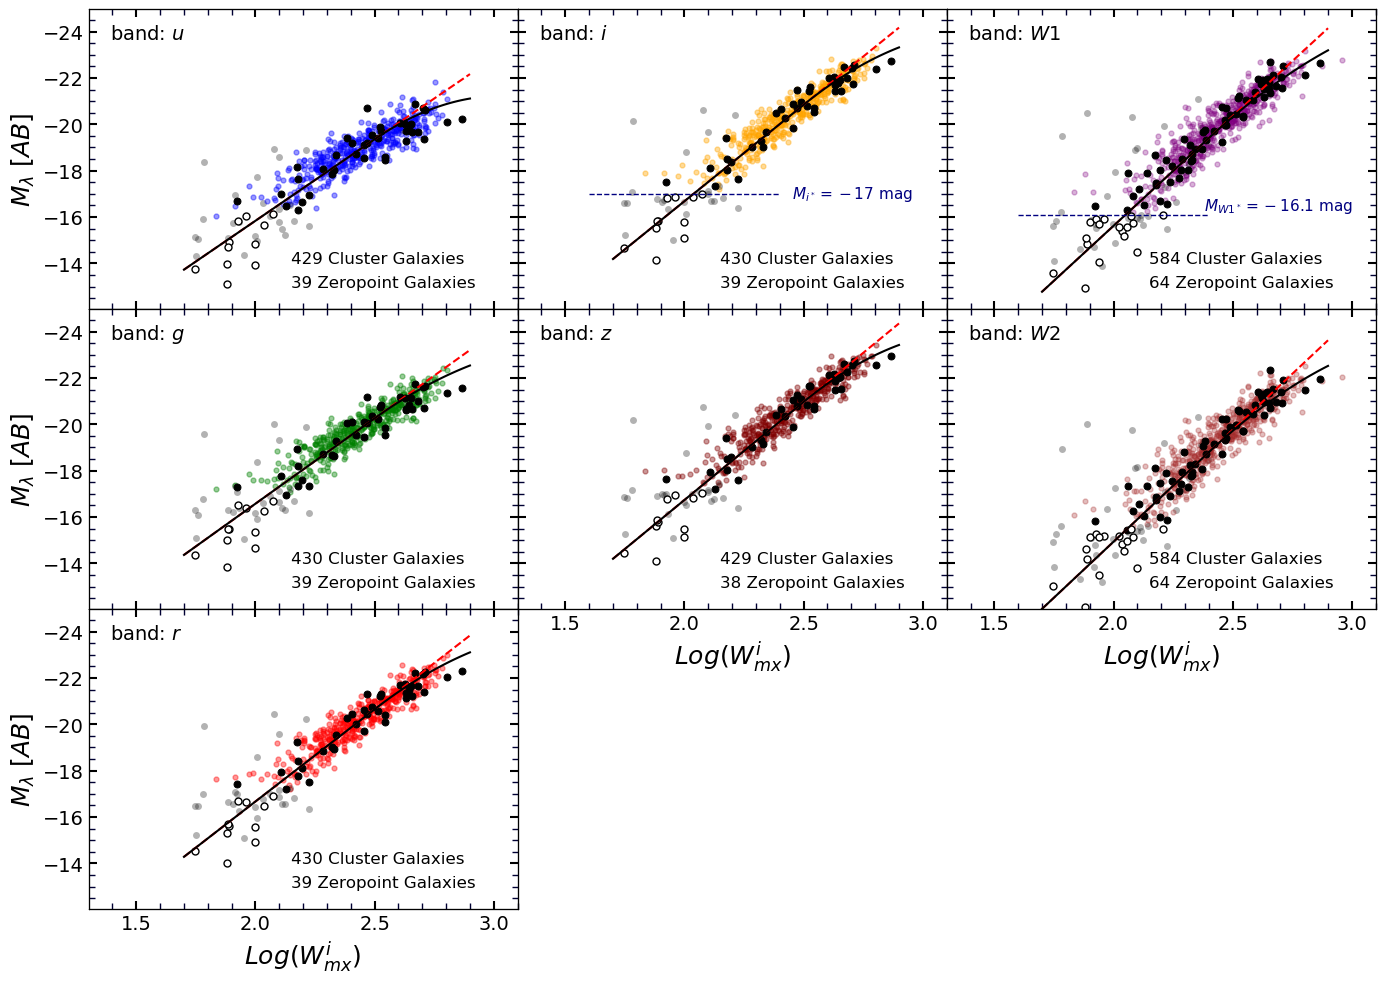

In [5]:
fig = py.figure(figsize=(13.99, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0



ax = plt.subplot(gs[p]); p+=1 
RMS_u  = makeTFandPLOT(ax, band = 'u', xLim = (1.3,3.1), yLim = (-11,-25))
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)

ax = plt.subplot(gs[p]); p+=1 
RMS_i  = makeTFandPLOT(ax, band = 'i', xLim = (1.3,3.1), yLim = (-11,-25))
plt.setp(ax.get_yticklabels(), visible=False)

ax = plt.subplot(gs[p]); p+=1 
RMS_w1  = makeTFandPLOT(ax, band = 'w1', xLim = (1.3,3.1), yLim = (-11,-25))
plt.setp(ax.get_yticklabels(), visible=False)


ax = plt.subplot(gs[p]); p+=1 
RMS_g  = makeTFandPLOT(ax, band = 'g', xLim = (1.3,3.1), yLim = (-11,-25))
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)


ax = plt.subplot(gs[p]); p+=1 
RMS_z  = makeTFandPLOT(ax, band = 'z', xLim = (1.3,3.1), yLim = (-11,-25))
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
RMS_w2  = makeTFandPLOT(ax, band = 'w2', xLim = (1.3,3.1), yLim = (-11,-25))
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
RMS_r  = makeTFandPLOT(ax, band = 'r', xLim = (1.3,3.1), yLim = (-11,-25))
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

plt.subplots_adjust(hspace=0, wspace=0)

In [6]:
print RMS_u
print RMS_g
print RMS_r
print RMS_i
print RMS_z
print RMS_w1
print RMS_w2

[0.5588606330668184, 0.6016345326424185, 0.5625354840852624, 0.4878613962223323, 0.8160215845079952]
[0.4636557514734231, 0.5572625682188251, 0.4845812400247142, 0.4803335058972559, 0.37797125715120333]
[0.47145568110212066, 0.5836995187454977, 0.5247169422459432, 0.5136929177470129, 0.3142323736901128]
[0.47481520963237467, 0.5798254832636913, 0.563249360944794, 0.5174923896082447, 0.3927767459422937]
[0.47940679446957507, 0.5717941489798007, 0.562036023630827, 0.5198511346270297, 0.40390964750383246]
[0.563775673455109, 0.6568853345029821, 0.6089905926345963, 0.5662652144843624, 0.4827149672270198]
[0.6126659389017989, 0.6769671148527397, 0.6402506986035071, 0.5733652745988381, 0.5641856144261134]


u:  [-0.0243997  -0.86217619 -6.98090537]
g:  [-0.01168426 -0.38866038 -2.62803446]
r:  [ -0.04358023  -1.63809007 -14.8307324 ]
i:  [-0.0277935  -1.01618513 -8.68936204]
z:  [-0.02873967 -1.05875529 -9.15734311]
w1:  [-0.01488638 -0.52343314 -3.94385739]
w2:  [-0.01546413 -0.5423403  -4.06676489]


(0.33, 0.7)

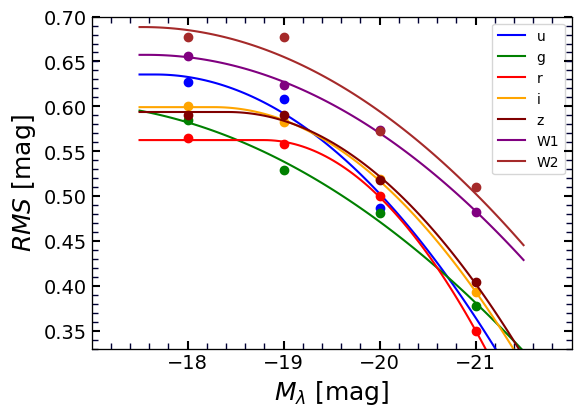

In [7]:
def myCurve(x, a, b, c):
    
    x0 = -b/2./a
    y = a*x**2+b*x+c
    
    indx, = np.where(x>=x0)
    y[indx] = a*x0**2+b*x0+c
    return y

    

dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

M = [-18, -19, -20, -21]
RMS_u  = [0.5938833938060076, 0.6272887429634803, 0.6085715746576826, 0.48631597577675545, 0.37]
RMS_g  = [0.5008535510992298, 0.5852697221089109, 0.5291397857586407, 0.4808229018397677, 0.3779559183402251]
RMS_r  = [0.5036898200300859, 0.5646147266516882, 0.557527467467175, 0.5142875542762689, 0.3142540251549993]
RMS_i  = [0.49973027371821516, 0.6006497272110864, 0.582526400838503, 0.5187582732290118, 0.3930157881987031]
RMS_z  = [0.5129024347890906, 0.5907417833030253, 0.5899381031748383, 0.5175218858552549, 0.40366070388336045]
RMS_w1 = [0.5766114245492323, 0.6559133464793239, 0.6239042326693797, 0.5737377877528624, 0.48218315174855253]
RMS_w2 = [0.6234315490322795, 0.6776837392341366, 0.6770480594443984, 0.5724921937387407, 0.5633219937784727]





RMS_r[4] = 0.35
RMS_r[3] = 0.5
RMS_i[1] = 0.60
RMS_w2[4] = 0.51

v = np.linspace(-21.5,-17.5,100)

fig = py.figure(figsize=(6,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)



plt.plot(M[0:3], RMS_u[1:4], 'bo')
c = np.polyfit(M, RMS_u[1:], 2)
# ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'b-')
fit, cov = curve_fit(myCurve, M, RMS_u[1:])
ax.plot(v, myCurve(v, fit[0], fit[1], fit[2]), 'b-', label='u')
print 'u: ', fit
ST = ['%.3f'%fit[i]+'$\pm$'+'%.3f'%np.sqrt(cov[i][i]) for i in [0,1,2]]

plt.plot(M, RMS_g[1:], 'go')
c = np.polyfit(M, RMS_g[1:], 2)
# ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'g-')
fit, cov = curve_fit(myCurve, M, RMS_g[1:])
ax.plot(v, myCurve(v, fit[0], fit[1], fit[2]), 'g-', label='g')
print 'g: ', fit

plt.plot(M, RMS_r[1:], 'ro')
c = np.polyfit(M, RMS_r[1:], 2)
# ax.plot(v,c[0]*v**2+c[1]*v+c[2], '-', color=dye['r'])
fit, cov = curve_fit(myCurve, M, RMS_r[1:])
ax.plot(v, myCurve(v, fit[0], fit[1], fit[2]), 'r-', label='r')
print 'r: ', fit

plt.plot(M, RMS_i[1:], 'o', color=dye['i'])
c = np.polyfit(M, RMS_i[1:], 2)
# ax.plot(v,c[0]*v**2+c[1]*v+c[2], '-', color=dye['i'])
fit, cov = curve_fit(myCurve, M, RMS_i[1:])
ax.plot(v, myCurve(v, fit[0], fit[1], fit[2]), '-', color=dye['i'], label='i')
print 'i: ', fit


plt.plot(M, RMS_z[1:], 'o', color=dye['z'])
c = np.polyfit(M, RMS_z[1:], 2)
# ax.plot(v,c[0]*v**2+c[1]*v+c[2], '-', color=dye['z'])
fit, cov = curve_fit(myCurve, M, RMS_z[1:])
ax.plot(v, myCurve(v, fit[0], fit[1], fit[2]), '-', color=dye['z'], label='z')
print 'z: ', fit


plt.plot(M, RMS_w1[1:], 'o', color=dye['w1'])
c = np.polyfit(M, RMS_w1[1:], 2)
# ax.plot(v,c[0]*v**2+c[1]*v+c[2], '-', color=dye['w1'])
fit, cov = curve_fit(myCurve, M, RMS_w1[1:])
ax.plot(v, myCurve(v, fit[0], fit[1], fit[2]), '-', color=dye['w1'], label='W1')
print 'w1: ', fit


plt.plot(M, RMS_w2[1:], 'o', color=dye['w2'])
c = np.polyfit(M, RMS_w2[1:], 2)
# ax.plot(v,c[0]*v**2+c[1]*v+c[2], '-', color=dye['w2'])
fit, cov = curve_fit(myCurve, M, RMS_w2[1:])
ax.plot(v, myCurve(v, fit[0], fit[1], fit[2]), '-', color=dye['w2'], label='W2')
print 'w2: ', fit

yLim = (0.33,0.70)
xLim = (-17,-22)

ax.set_xlabel(r'$M_{\lambda}$'+' [mag]', fontsize=18)
ax.set_ylabel(r'$RMS$'+' [mag]', fontsize=18)

ax.legend()


ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-21,-17,1))

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  
    x_ax.set_xticks(np.arange(-21,-17,1))


for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
        
ax.set_xlim(xLim)
ax.set_ylim(yLim)